## 1. Superfiltering
### 1.1. Implementation

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
from datasets import Dataset
import pandas as pd
from tqdm import tqdm
import numpy as np

tqdm.pandas()


def get_perplexity_and_embedding_whole_text(tokenizer, model, text, max_length):

    try:
        input_ids = tokenizer.encode(
            text, return_tensors="pt", truncation=True, max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids.contiguous())
        loss = outputs.loss
        perplexity = torch.exp(loss)

        return perplexity.to("cpu").item(), loss.to("cpu").item()

    except Exception as e:
        print(e)
        return np.nan, np.nan


# Used to get the ppl and emb for part of input, used in conditional version, and token-wise loss
def get_perplexity_and_embedding_part_text(
    tokenizer, model, text, target_span, max_length
):

    try:
        input_ids = tokenizer.encode(
            text, return_tensors="pt", truncation=True, max_length=max_length
        ).to(device)

        start_index = text.rfind(target_span)
        start_token = len(tokenizer.encode(text[:start_index]))

        labels = input_ids.clone()
        labels[0, :start_token] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=labels)

        loss = outputs.loss
        perplexity = torch.exp(loss)

        return perplexity.to("cpu").item(), loss.to("cpu").item()

    except Exception as e:
        print(e)
        return np.nan, np.nan


# Used to get the ppl and emb for the whole input
def compute_ifd(row):
    ppl_xy, loss_xy = get_perplexity_and_embedding_part_text(
        tokenizer, model, row["full_text"], row["response"], max_length
    )

    ppl_y, loss_y = get_perplexity_and_embedding_whole_text(
        tokenizer, model, row["response"], max_length
    )

    ifd = ppl_xy / ppl_y

    return ifd, ppl_y, loss_y, ppl_xy, loss_xy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    output_hidden_states=True,
).to(device)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

max_length = min(1024, tokenizer.model_max_length)
print("Max length:", max_length)

# Load the data
df = pd.read_csv("../data/huge_corpus/train.csv").reset_index(drop=True).dropna()
df["full_text"] = df["prompt"] + " " + df["response"]

df[["ifd", "perplexity_y", "loss_y", "perplexity_xy", "loss_xy"]] = df.progress_apply(
    compute_ifd, axis=1, result_type="expand"
)
df

In [ ]:
df.to_csv("../data/study/huge_corpus/train_ifd.csv", index=False)

## 1.2. Study

NaN rows: 36
IFD > 1 (useless promtps): 455
IFD < 1 (useful promtps): 144435


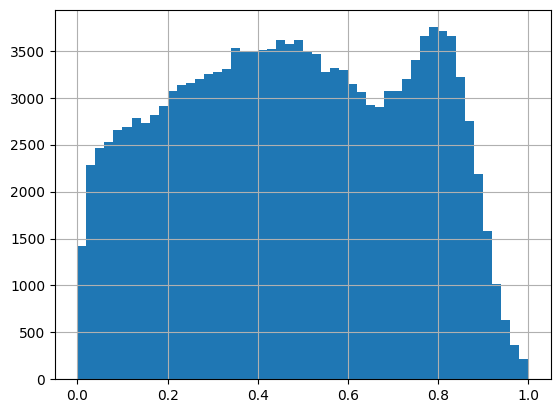

In [1]:
import pandas as pd

df = pd.read_csv("../data/study/huge_corpus/train_ifd.csv")

print("NaN rows:", df["ifd"].isna().sum())
print("IFD > 1 (useless promtps):", len(df[df["ifd"] >= 1]))
print("IFD < 1 (useful promtps):", len(df[df["ifd"] < 1]))

df[df["ifd"] < 1]["ifd"].hist(bins=50)
df_50 = df.sort_values("ifd").head(len(df) // 2).reset_index(drop=True)

In [2]:
df_50

,prompt,response,ifd,perplexity_y,loss_y,perplexity_xy,loss_xy,full_text
0,Which card in Magic can create an infinite bli...,Abdel Adrian,0.000016,80659.101562,11.297987,1.280036,0.246888,Which card in Magic can create an infinite bli...
1,Which of the following cards can be used in a ...,Dualcaster Mage,0.000018,62191.246094,11.037970,1.098073,0.093556,Which of the following cards can be used in a ...
2,Which card allows you to create a combo involv...,Puresteel Paladin,0.000021,53952.367188,10.895857,1.120931,0.114160,Which card allows you to create a combo involv...
3,Which card can be used to create infinite acti...,Dross Scorpion,0.000028,117302.812500,11.672514,3.229506,1.172329,Which card can be used to create infinite acti...
4,Which card could be used to create an infinite...,Cryptolith Rite,0.000063,17172.839844,9.751084,1.077295,0.074453,Which card could be used to create an infinite...
...,...,...,...,...,...,...,...,...
72458,Explain the significance of Planeswalkers in ...,Planeswalkers in Standard decks offer versatil...,0.480115,72.938011,4.289610,35.018635,3.555880,Explain the significance of Planeswalkers in ...
72459,What combo can you perform with Emiel the Bles...,You can create an infinite combo where you act...,0.480117,22.122330,3.096587,10.621300,2.362861,What combo can you perform with Emiel the Bles...
72460,Can you activate [[Beledros]] Witherbloom's ab...,Yes to both. Flickering either one results in ...,0.480134,137.731003,4.925303,66.129318,4.191612,Can you activate [[Beledros]] Witherbloom's ab...
72461,What is the effect of Torpor Orb on triggered ...,Look at the permanent as it exists on the batt...,0.480149,23.971418,3.176862,11.509862,2.443204,What is the effect of Torpor Orb on triggered ...


## 2. Diversity
## 2.1. Embeddings

In [3]:
from sentence_transformers import SentenceTransformer

embedding_model = "mixedbread-ai/mxbai-embed-large-v1"

model = SentenceTransformer(embedding_model)

embeddings = model.encode(
    df_50["full_text"].tolist(),
    batch_size=512,
    show_progress_bar=True,
    normalize_embeddings=True,
)

df_50["embeddings"] = [embeddings[i] for i in range(embeddings.shape[0])]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/142 [00:00<?, ?it/s]

### 2.2. Facility Location

In [10]:
from apricot.functions.facilityLocation import FacilityLocationSelection
import numpy as np

embeddings = np.stack(df_50["embeddings"].to_list())

for psize in [0.2, 0.1, 0.05]:
    selector = FacilityLocationSelection(n_samples=int(len(df) * psize), verbose=True)
    X, y = selector.fit_transform(embeddings, y=df_50.index.to_numpy())
    df_50.iloc[y].to_csv(
        f"../data/study/huge_corpus/train_ifd_{int(psize*100)}_div.csv", index=False
    )

100%|██████████| 29.0k/29.0k [11:19<00:00, 42.7it/s]  
100%|██████████| 14.5k/14.5k [03:08<00:00, 76.8it/s]  
100%|██████████| 7.25k/7.25k [01:00<00:00, 119it/s]  


: 